# Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction

*M. Zimmermann, Z. Abbas, K. Dzieciol and N. J. Shah, "Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction," in IEEE Transactions on Medical Imaging, vol. 37, no. 2, pp. 626-637, Feb. 2018, doi: 10.1109/TMI.2017.2771504.*

# Load data

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
import sys

sys.path.insert(0, "../src")

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch

from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.recon.mirage import MIRAGE
from juart.recon.monitoring import ConvergenceMonitor
from juart.vis import MultiPlotter

torch.set_num_threads(16)
torch.set_grad_enabled(False)

## Load sequence parameters

In [3]:
with h5py.File(os.path.join('..', 'LocalData', 'Simulations', 'qrage_info.h5'), 'r') as f:
    num_spokes = f['num_spokes'][...]
    num_sets = f['num_sets'][...]
    num_echoes = f['num_echoes'][...]
    num_partitions_per_block = f['num_partitions_per_block'][...]
    num_autocalibration_lines = f['num_autocalibration_lines'][...]
    acceleration_factor = f['acceleration_factor'][...]
    matrix_size = f['matrix_size'][...]
    readout_bandwidth = f['readout_bandwidth'][...]
    dTI = f['dTI'][...]
    TI0 = f['TI0'][...]
    dTE = f['dTE'][...]
    TE0 = f['TE0'][...]
    TR = f['TR'][...]

In [4]:
nUS = num_spokes
iS = matrix_size[2]//2

In [5]:
filepath = '/workspaces/juart-dev'
# filepath = '/home/jovyan/juart-dev'
h5_preproc_fname = os.path.join('LocalData', 'Simulations','qrage_grappa_pytorch.h5')
h5_image_fname =  os.path.join('LocalData', 'Simulations','mz_me_mpnrage3d_grappa_%s_%s.h5' % (iS, nUS))

In [6]:
full_h5_preproc_fname = os.path.join(filepath, h5_preproc_fname)
full_h5_image_fname = os.path.join(filepath, h5_image_fname)

In [7]:
print(full_h5_preproc_fname)
print(full_h5_image_fname)

/workspaces/juart-dev/LocalData/Simulations/qrage_grappa_pytorch.h5
/workspaces/juart-dev/LocalData/Simulations/mz_me_mpnrage3d_grappa_0_16.h5


In [8]:
with h5py.File(
    full_h5_preproc_fname,
    "r",
    libver="latest",
    swmr=True,
) as h5_preproc_file:
    nC, nX, nY, nZ, nS = h5_preproc_file["C"].shape[:5]
    nC, spokes, baseresolution, nZ, nS, nTI, nTE = h5_preproc_file["d"].shape

    shape = (nX, nY, nZ, 1, nTI, nTE)

    print("Reconstructing slice %s of %s." % (iS, nS))

    nK = baseresolution * nUS

    # Read data
    C = h5_preproc_file["C"][:, :, :, :, iS : iS + 1, :, :]
    k = h5_preproc_file["k"][:, :nUS, :, :, :, :, :]
    d = h5_preproc_file["d"][:, :nUS, :, :, iS : iS + 1, :, :] / 1e3 / 50

    # nC = 1

    k = k.reshape((2, nK, 1, nTI, nTE))
    d = d.reshape((nC, nK, 1, nTI, nTE))

    C = torch.tensor(C, dtype=torch.complex64)
    k = torch.tensor(k, dtype=torch.float32)
    d = torch.tensor(d, dtype=torch.complex64)

Reconstructing slice 0 of 1.


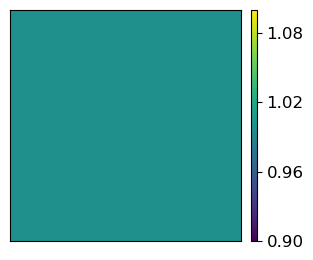

In [9]:
MultiPlotter(
    np.abs(C[..., 0, 0].numpy()),
    (1, nC),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

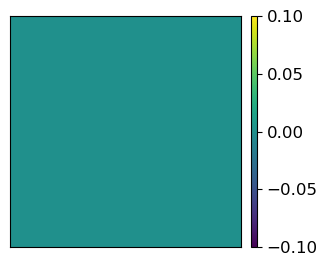

In [10]:
MultiPlotter(
    np.angle(C[..., 0, 0].numpy()),
    (1, nC),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [11]:
AHd = nonuniform_fourier_transform_adjoint(
    k,
    d,
    (nX, nY),
    modeord=0,
    isign=1,
)
AHd = torch.sum(torch.conj(C) * AHd, dim=0)

In [12]:
H = nonuniform_transfer_function(k, (1, nX, nY, nZ, 1, nTI, nTE), oversampling=(2, 2))

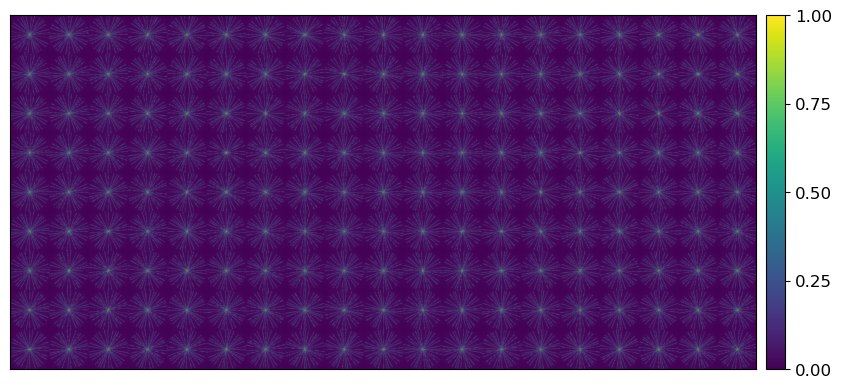

In [13]:
MultiPlotter(
    np.abs(H[0, :, :, 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

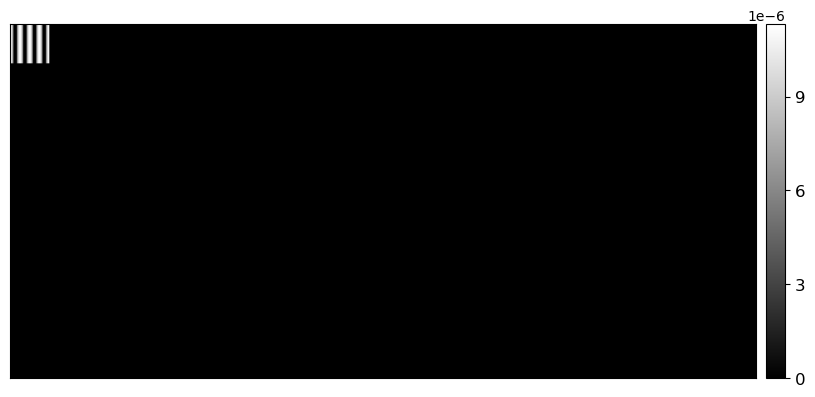

In [14]:
MultiPlotter(
    np.abs(AHd[:, :, 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
#     vmin=0,
#     vmax=0.0125,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

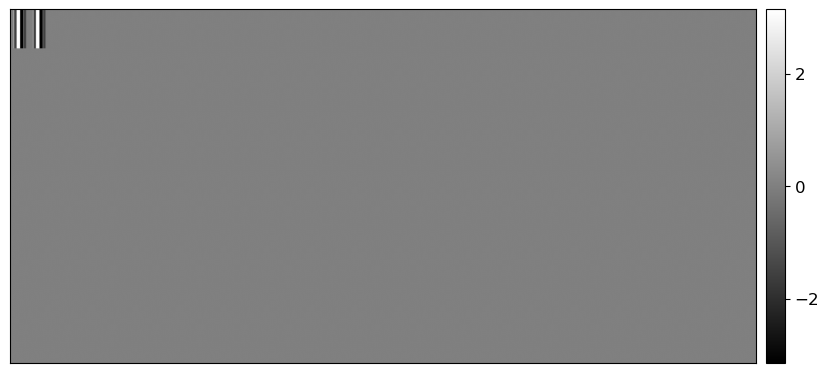

In [14]:
MultiPlotter(
    np.angle(AHd[..., 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
    vmin=-np.pi,
    vmax=np.pi,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [15]:
support = torch.abs(C).max(dim=0).values > 0

cm = ConvergenceMonitor(support + torch.zeros(shape), support, logfile=None)

solver = MIRAGE(
    C[..., 0, 0],
    AHd,
    H,
    lambda_wavelet=1e-3,
    lambda_hankel=None,
    lambda_casorati=None,
    weight_wavelet=1,
    weight_hankel=0.5,
    weight_casorati=0.5,
    cg_maxiter=5,
    admm_maxiter=30,
    callback=cm.callback,
)

[Convergence Monitor] Initialization complete.


In [16]:
# Run MIRAGE reconstruction
solver.solve()

[ADMM] Iter: 00 Prim Res: 5.62E-04 Dual Res: 5.62E-04 Rel Res: 1.00E+00:   3%|▎         | 1/30 [00:07<03:45,  7.77s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  0.000e+00


[ADMM] Iter: 01 Prim Res: 3.70E-04 Dual Res: 2.33E-04 Rel Res: 1.00E+00:   7%|▋         | 2/30 [00:14<03:26,  7.39s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.114e+00


[ADMM] Iter: 02 Prim Res: 2.66E-04 Dual Res: 1.12E-04 Rel Res: 1.00E+00:  10%|█         | 3/30 [00:22<03:18,  7.34s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.300e+00


[ADMM] Iter: 03 Prim Res: 1.95E-04 Dual Res: 7.32E-05 Rel Res: 1.00E+00:  13%|█▎        | 4/30 [00:29<03:11,  7.36s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.388e+00


[ADMM] Iter: 04 Prim Res: 1.44E-04 Dual Res: 5.14E-05 Rel Res: 1.00E+00:  17%|█▋        | 5/30 [00:36<03:02,  7.30s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.191e+00


[ADMM] Iter: 05 Prim Res: 1.07E-04 Dual Res: 3.73E-05 Rel Res: 1.00E+00:  20%|██        | 6/30 [00:44<02:54,  7.29s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.257e+00


[ADMM] Iter: 06 Prim Res: 8.01E-05 Dual Res: 2.74E-05 Rel Res: 1.00E+00:  23%|██▎       | 7/30 [00:51<02:47,  7.27s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.230e+00


[ADMM] Iter: 07 Prim Res: 5.98E-05 Dual Res: 2.03E-05 Rel Res: 1.00E+00:  27%|██▋       | 8/30 [00:58<02:40,  7.30s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.383e+00


[ADMM] Iter: 08 Prim Res: 4.47E-05 Dual Res: 1.51E-05 Rel Res: 1.00E+00:  30%|███       | 9/30 [01:05<02:33,  7.29s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.268e+00


[ADMM] Iter: 09 Prim Res: 3.35E-05 Dual Res: 1.13E-05 Rel Res: 1.00E+00:  33%|███▎      | 10/30 [01:13<02:25,  7.28s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.249e+00


[ADMM] Iter: 10 Prim Res: 2.50E-05 Dual Res: 8.43E-06 Rel Res: 1.00E+00:  37%|███▋      | 11/30 [01:20<02:18,  7.27s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.257e+00


[ADMM] Iter: 11 Prim Res: 1.87E-05 Dual Res: 6.30E-06 Rel Res: 1.00E+00:  40%|████      | 12/30 [01:27<02:10,  7.27s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.273e+00


[ADMM] Iter: 12 Prim Res: 1.40E-05 Dual Res: 4.71E-06 Rel Res: 1.00E+00:  43%|████▎     | 13/30 [01:34<02:03,  7.27s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.277e+00


[ADMM] Iter: 13 Prim Res: 1.05E-05 Dual Res: 3.53E-06 Rel Res: 1.00E+00:  47%|████▋     | 14/30 [01:42<01:56,  7.27s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.250e+00


[ADMM] Iter: 14 Prim Res: 7.85E-06 Dual Res: 2.64E-06 Rel Res: 1.00E+00:  50%|█████     | 15/30 [01:49<01:49,  7.27s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.283e+00


[ADMM] Iter: 15 Prim Res: 5.88E-06 Dual Res: 1.97E-06 Rel Res: 1.00E+00:  53%|█████▎    | 16/30 [01:56<01:41,  7.27s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.257e+00


[ADMM] Iter: 16 Prim Res: 4.40E-06 Dual Res: 1.48E-06 Rel Res: 1.00E+00:  57%|█████▋    | 17/30 [02:04<01:34,  7.27s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.280e+00


[ADMM] Iter: 17 Prim Res: 3.29E-06 Dual Res: 1.11E-06 Rel Res: 1.00E+00:  60%|██████    | 18/30 [02:11<01:27,  7.28s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.312e+00


[ADMM] Iter: 18 Prim Res: 2.47E-06 Dual Res: 8.28E-07 Rel Res: 1.00E+00:  63%|██████▎   | 19/30 [02:18<01:20,  7.29s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.300e+00


[ADMM] Iter: 19 Prim Res: 1.85E-06 Dual Res: 6.20E-07 Rel Res: 1.00E+00:  67%|██████▋   | 20/30 [02:25<01:12,  7.29s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.296e+00


[ADMM] Iter: 20 Prim Res: 1.38E-06 Dual Res: 4.64E-07 Rel Res: 1.00E+00:  70%|███████   | 21/30 [02:33<01:05,  7.29s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.279e+00


[ADMM] Iter: 21 Prim Res: 1.04E-06 Dual Res: 3.47E-07 Rel Res: 1.00E+00:  73%|███████▎  | 22/30 [02:40<00:58,  7.29s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.309e+00


[ADMM] Iter: 22 Prim Res: 7.75E-07 Dual Res: 2.60E-07 Rel Res: 1.00E+00:  77%|███████▋  | 23/30 [02:47<00:51,  7.30s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.299e+00


[ADMM] Iter: 23 Prim Res: 5.81E-07 Dual Res: 1.95E-07 Rel Res: 1.00E+00:  80%|████████  | 24/30 [02:54<00:42,  7.09s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  6.600e+00


[ADMM] Iter: 24 Prim Res: 4.35E-07 Dual Res: 1.46E-07 Rel Res: 1.00E+00:  83%|████████▎ | 25/30 [03:01<00:34,  6.94s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  6.601e+00


[ADMM] Iter: 25 Prim Res: 3.26E-07 Dual Res: 1.09E-07 Rel Res: 1.00E+00:  87%|████████▋ | 26/30 [03:07<00:27,  6.83s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  6.575e+00


[ADMM] Iter: 26 Prim Res: 2.44E-07 Dual Res: 8.17E-08 Rel Res: 1.00E+00:  90%|█████████ | 27/30 [03:14<00:20,  6.76s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  6.606e+00


[ADMM] Iter: 27 Prim Res: 1.83E-07 Dual Res: 6.12E-08 Rel Res: 1.00E+00:  93%|█████████▎| 28/30 [03:20<00:13,  6.75s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  6.703e+00


[ADMM] Iter: 28 Prim Res: 1.37E-07 Dual Res: 4.58E-08 Rel Res: 1.00E+00:  97%|█████████▋| 29/30 [03:27<00:06,  6.74s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  6.730e+00


[ADMM] Iter: 29 Prim Res: 1.02E-07 Dual Res: 3.44E-08 Rel Res: 1.00E+00: 100%|██████████| 30/30 [03:34<00:00,  7.15s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  6.717e+00


tensor([ 4.0951e-10, -6.6236e-14,  0.0000e+00,  ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00])

In [18]:
z_image = solver.solver.results["v"].view(torch.complex64).reshape(shape)

/tmp/ipykernel_4195/2121847719.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.abs(z_image[..., 0, 0, :, :]),


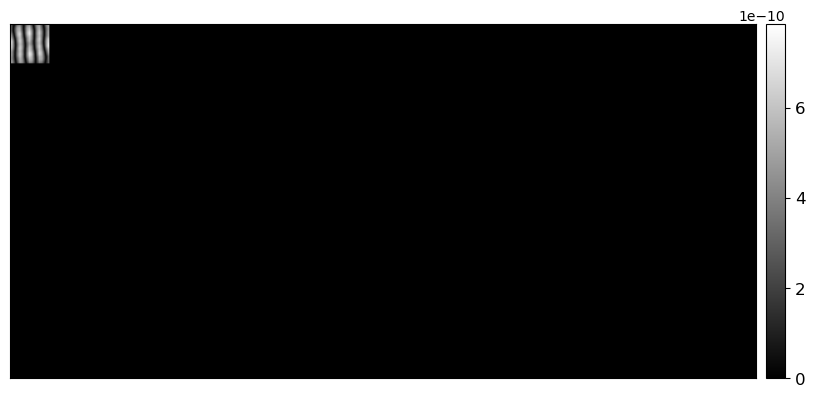

In [19]:
MultiPlotter(
    np.abs(z_image[..., 0, 0, :, :]),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
#     vmin=0,
#     vmax=20,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [ ]:
with h5py.File(full_h5_image_fname, "w", libver='latest') as h5_preproc_file:
    dset = h5_preproc_file.create_dataset("x", data=z_image, chunks=(nX, nY, nZ, 1, 1, 1))

In [ ]:
# plt.savefig(os.path.join(filepath, 'reconstruction_idea.png'), dpi=1200, transparent=True)